In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

2024-11-22 01:47:07.067867: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 01:47:07.080397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732214827.091988  152755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732214827.095118  152755 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 01:47:07.108504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def load_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return audio, sr

def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)

def imgSpec(ms_feature):
    fig, ax = plt.subplots()
    ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    #print(ms_feature.shape)
    img = librosa.display.specshow(ms_dB, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram');
    
def hear_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    #print("\t", end="")
    ipd.display(ipd.Audio(data=audio, rate=sr))
    
    
def get_audio_info(path, show_melspec=False, label=None):
    spec = wav2melSpec(path)
    if label is not None:
        pass
        #print("Label:", label)
    if show_melspec is not False:
        imgSpec(spec)
    hear_audio(path)

In [29]:
MFCC_NUM =  28
SAMPLING_RATE = 44100 
MFCC_MAX_LEN = 128 

def wav2mfcc(wave, max_len=MFCC_MAX_LEN):
    mfcc = librosa.feature.mfcc(y=wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [4]:
breath_path =  "SafeVision/breath detection\Breath_Dataset2"

In [30]:
from tqdm import tqdm

DATASET_PATH = r"Breath_and_snoring_Dataset"

SAMPLING_RATE = 44100  # Стандартная частота дискретизации для librosa
# def wav2mfcc(audio, sr=SAMPLING_RATE, n_mfcc=256):
#     # Вычисление MFCC спектрограммы
#     # mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
#     # Приведение к фиксированному размеру по времени (128 фреймов)
#     # mfcc = librosa.util.fix_length(mfcc, size=128, axis=1)
#     # audio, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    
#     # Преобразуем в спектрограмму с использованием STFT (Short-Time Fourier Transform)
#     spectrogram = librosa.stft(audio, n_fft=320, hop_length=32)
#     spectrogram = np.abs(spectrogram)
#     mfcc = librosa.feature.mfcc(S=librosa.power_to_db(spectrogram), n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)
#     return mfcc

mfcc_spectograms = []

classes = ['0', '1', '2']

for class_label in classes:
    class_path = os.path.join(DATASET_PATH, class_label)
    
    if os.path.exists(class_path):
        files_in_dir = os.listdir(class_path)
        
        for file_name in tqdm(files_in_dir, desc=f"Processing class {class_label}", unit="file"):
            if file_name.endswith('.wav'):
                try:
                    audio, _ = librosa.load(os.path.join(class_path, file_name), sr=SAMPLING_RATE)

                    spectrogram = np.expand_dims(wav2mfcc(audio), axis=-1)

                    mfcc_spectograms.append((spectrogram, int(class_label)))

                    audio_shifted = librosa.effects.pitch_shift(audio, sr=SAMPLING_RATE, n_steps=12)
                    spectrogram_shifted = np.expand_dims(wav2mfcc(audio_shifted), axis=-1)

                    mfcc_spectograms.append((spectrogram_shifted, int(class_label)))
                    
                    #print(f"Processed file: {file_name} from class {class_label}")
                    
                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Class directory {class_path} does not exist.")

print(f"Total processed MFCC spectrograms: {len(mfcc_spectograms)}")

X = [x[0] for x in mfcc_spectograms]  # Спектрограммы
y = [x[1] for x in mfcc_spectograms]  # Метки классов

X = np.array(X)
y = np.array(y)

Processing class 2: 100%|██████████| 257/257 [00:04<00:00, 63.77file/s]


Total processed MFCC spectrograms: 2942


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2647, 28, 128, 1)
Shape of X_test: (295, 28, 128, 1)
Shape of y_train: (2647,)
Shape of y_test: (295,)


In [7]:
from tensorflow.keras.utils import to_categorical

# Преобразуем метки в формат one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)


In [19]:
from tensorflow.keras import Sequential, layers

dropout = 0.1
input_dim = (28, 128, 1)
output_dim_vocab = 3

model = Sequential([
    #1 layer
    layers.Conv2D(filters=32, kernel_size=[6, 6], strides=[2, 2], input_shape=input_dim, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation(activation='leaky_relu'),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Dropout(dropout),
    
    # 2 layer
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation(activation='relu'),
    layers.Dropout(dropout),
    
    # 3 conv layer
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation(activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(dropout),
    
    # 4 conv layer
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation(activation='relu'),
    layers.Dropout(dropout),
    
    layers.Flatten(),
    
    # Fully connected layer
    layers.Dense(256, activation="relu"),
    layers.Dropout(dropout),
    
    # Output layer
    layers.Dense(output_dim_vocab, activation="softmax"),
])


/home/egor/safeVision/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [21]:

model_path = 'models'

earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
checkpoint = ModelCheckpoint(f"{model_path}/model_snoring_and_breathing_28_128.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tb_callback = TensorBoard(f'{model_path}/logs', update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_delta=1e-10, patience=3, verbose=1, mode='auto')

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 64, 32)     │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 21, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 21, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 21, 128)     │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 21, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 21, 512)     │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 21, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 4, 21, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 10, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 10, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 2, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,621,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,615,491 (21.42 MB)

 Trainable params: 5,613,123 (21.41 MB)

 Non-trainable params: 2,368 (9.25 KB)

#Since I couldn't fix the snippet below. Even after trying different things. I'll stop Snoring.

In [23]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.1,
    epochs=5, 
    batch_size=64,
    callbacks=[earlystopper, checkpoint, reduceLROnPlat, tb_callback]
)

Epoch 1/5
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5237 - loss: 3.1385 - precision: 0.5267 - recall: 0.4979
Epoch 1: val_loss improved from inf to 1.15579, saving model to models/model_snoring_and_breathing_28_128.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5263 - loss: 3.0603 - precision: 0.5294 - recall: 0.5007 - val_accuracy: 0.4981 - val_loss: 1.1558 - val_precision: 0.5087 - val_recall: 0.4415 - learning_rate: 0.0010
Epoch 2/5
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6859 - loss: 0.6107 - precision: 0.6952 - recall: 0.6718
Epoch 2: val_loss improved from 1.15579 to 0.67408, saving model to models/model_snoring_and_breathing_28_128.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.6882 - loss: 0.6075 - precision: 0.6975 - recall: 0.6741 - val_accuracy: 0.7321 - val_loss: 0.6741 - val_precision: 0.7479 - val_recall: 0.6717 - learning_rate: 0.0010
Epoch 3/5
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8752 - loss: 0.3499 - 

In [26]:
MODEL_PATH = r'models/model_snoring_and_breathing_10e_28_128_2.keras'

In [27]:
model.save(MODEL_PATH)

In [49]:
from tensorflow.keras.models import load_model

model = load_model(MODEL_PATH)

In [24]:
# Оценка модели на тестовом наборе данных
test_loss, test_accuracy, pr, rc = model.evaluate(X_test, y_test, batch_size=64)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test precision: {pr}")
print(f"Test recall: {rc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9185 - loss: 0.2056 - precision: 0.9246 - recall: 0.9185
Test Loss: 0.16422605514526367
Test Accuracy: 0.9254237413406372
Test precision: 0.9317406415939331
Test recall: 0.9254237413406372


In [51]:
def preprocess_audio(file_path):
    # Загрузка аудиофайла
    wave, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    
    # Проверка длины
    if len(wave) == 0:
        raise ValueError("Аудиофайл пуст.")
    
    # Преобразование в MFCC
    mfcc = wav2mfcc(wave)
    
    # Добавление измерения для batch_size
    return np.expand_dims(mfcc, axis=0)  # Форма: (1, MFCC_NUM, MFCC_MAX_LEN)


In [52]:
def predict_from_file(file_path):
    # Предобработка аудиофайла
    input_data = preprocess_audio(file_path)
    
    # Предсказание
    prediction = model.predict(input_data)
    
    # Возвращаем результат
    return prediction


In [60]:
for i in range(100):
    file_path = f"D:\python\safevision\SafeVision/breath detection\Breath_and_snoring_Dataset/2/2_{i}.wav"

    prediction = predict_from_file(file_path)
    print("Результат предсказания:", prediction)

    predicted_class = np.argmax(prediction)
    print("Предсказанный класс:", predicted_class)

1/1 [==============================] - 0s 36ms/step
Результат предсказания: [[1.5301550e-08 2.3878022e-10 1.0000000e+00]]
Предсказанный класс: 2
1/1 [==============================] - 0s 30ms/step
Результат предсказания: [[6.0790200e-08 5.2845217e-10 9.9999988e-01]]
Предсказанный класс: 2
1/1 [==============================] - 0s 34ms/step
Результат предсказания: [[1.7463186e-16 4.5565589e-14 1.0000000e+00]]
Предсказанный класс: 2
1/1 [==============================] - 0s 31ms/step
Результат предсказания: [[1.4939724e-07 1.5209879e-07 9.9999964e-01]]
Предсказанный класс: 2
1/1 [==============================] - 0s 35ms/step
Результат предсказания: [[1.0740091e-10 3.0677201e-09 1.0000000e+00]]
Предсказанный класс: 2
1/1 [==============================] - 0s 32ms/step
Результат предсказания: [[5.3105582e-11 2.6111491e-09 1.0000000e+00]]
Предсказанный класс: 2
1/1 [==============================] - 0s 34ms/step
Результат предсказания: [[2.5323031e-08 4.8272714e-06 9.9999511e-01]]
Предсказ

In [61]:
SAMPLING_RATE = 44100  # Частота дискретизации
MFCC_NUM = 14
MFCC_MAX_LEN = 128

def split_audio(file_path, duration=1.0):

    wave, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    
    segment_length = int(sr * duration)
    
    segments = [
        wave[i:i + segment_length]
        for i in range(0, len(wave), segment_length)
        if len(wave[i:i + segment_length]) == segment_length  # Пропускаем последние неполные сегменты
    ]
    
    return segments

In [62]:
SAMPLING_RATE = 44100  # Частота дискретизации
MFCC_NUM = 14
MFCC_MAX_LEN = 128

def split_audio(file_path, duration=1.0, overlap=0.5):
    wave, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    segment_length = int(sr * duration)
    step = int(sr * (duration - overlap))
    segments = [
        wave[i:i + segment_length]
        for i in range(0, len(wave) - segment_length + 1, step)
    ]
    return segments


In [63]:
def predict_for_segments(segments, model):
    predictions = []
    for i, segment in enumerate(segments):
        mfcc = wav2mfcc(segment)
        
        input_data = np.expand_dims(mfcc, axis=0)

        prediction = model.predict(input_data)
        predictions.append(prediction)
    
    return predictions

In [67]:
file_path = r"D:\python\safevision\SafeVision\breath detection\Sounds_for_cute\dyihanie-rtom.mp3"

segments = split_audio(file_path)

predictions = predict_for_segments(segments, model)
yhat = []

for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)
    yhat.append(predicted_class)
    print(f"Сегмент {i + 1}: класс {predicted_class}, вероятности {prediction[0]}")

1/1 [==============================] - 0s 31ms/step
Сегмент 1: класс 2, вероятности [0.00267638 0.00343929 0.99388427]
Сегмент 2: класс 1, вероятности [0.18968283 0.6701548  0.14016238]
Сегмент 3: класс 1, вероятности [1.7019832e-07 9.9998701e-01 1.2923519e-05]
Сегмент 4: класс 1, вероятности [1.6708505e-04 8.3018148e-01 1.6965142e-01]
Сегмент 5: класс 1, вероятности [5.7119828e-06 9.9675924e-01 3.2351161e-03]
Сегмент 6: класс 1, вероятности [0.3513791  0.62952876 0.01909218]
Сегмент 7: класс 1, вероятности [6.633049e-05 9.032878e-01 9.664583e-02]
Сегмент 8: класс 2, вероятности [4.0845090e-04 3.3187538e-01 6.6771615e-01]
Сегмент 9: класс 1, вероятности [1.3399396e-04 9.9894029e-01 9.2574634e-04]
Сегмент 10: класс 1, вероятности [9.3152194e-06 8.2451230e-01 1.7547832e-01]
Сегмент 11: класс 1, вероятности [3.4082535e-05 9.8770952e-01 1.2256476e-02]
Сегмент 12: класс 1, вероятности [0.01600933 0.96598554 0.01800507]
Сегмент 13: класс 1, вероятности [8.3916211e-06 9.9796730e-01 2.0241858e

C:\Temp\ipykernel_20628\1587663247.py:26: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  c = collections.BrokenBarHCollection(


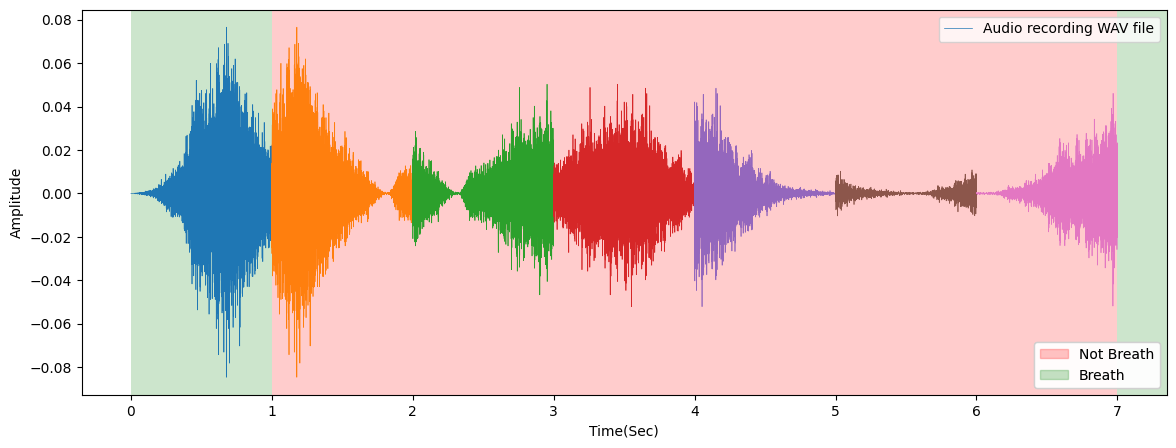

In [68]:
import matplotlib.collections as collections
import matplotlib.patches as mpatches

segments = split_audio(file_path, duration=1.0, overlap=0.5)

segments = segments[:7]

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (14,5)

x = np.linspace(0, len(segments) * 1.0, len(segments))

for i, segment in enumerate(segments):
    segment_time = np.linspace(i, i + 1, len(segment))
    ax.plot(segment_time, segment, linewidth=0.5)

for i in range(len(yhat)):
    x_start = i
    x_end = i + 1

    yrange = (4*10000, -6*10000)
    
    color = 'green' if yhat[i] == 2 else 'red'
    alpha = 0.2
    
    c = collections.BrokenBarHCollection(
        [(x_start, x_end - x_start)], yrange, facecolor=color, alpha=alpha
    )
    ax.add_collection(c)

red_patch = mpatches.Patch(color='red', label='Not Breath', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='Breath', alpha=0.2)

leg1 = ax.legend(labels=['Audio recording WAV file'], loc=1)
leg2 = ax.legend(handles=[red_patch, green_patch], loc=4)

ax.add_artist(leg1)
ax.add_artist(leg2)

plt.xlabel('Time(Sec)')
plt.ylabel('Amplitude')
plt.show()